### This script is for reading raw CDR data and constructing time-series data structure (and save it as a CSV file)

In [1]:
%matplotlib inline

import sys
sys.path.append('../python/')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imp
import cdr
import json
import os.path
from scipy.spatial.distance import cosine
from pandas.io.json import json_normalize

imp.reload(cdr)

print ("Libraries loaded")



Libraries loaded


In [2]:
# aaa = pd.read_csv('../../data/CDR/sms-call-internet-mi-2013-11-27.txt', delimiter='\t', header=None) 
# aaa.columns = ["cellId", "time", "countryCode", "smsIn", "smsOut","callIn", "callOut", "internet"]
# print ("Grid file loaded")

# # change miliseconds to datetime
# aaa.index = pd.to_datetime(aaa['time'],unit='ms',utc=True)
# aaa.index = aaa.index.tz_localize('UTC').tz_convert('Europe/Rome')
# aaa['date'] = aaa.index
# aaa['time_hour'] = aaa.index.hour
# aaa['month'] = aaa.index.month
# aaa['day'] = aaa.index.day
# # aaa = aaa.groupby(['cellId','month','day','time_hour'], as_index=False)
# aaa = aaa.groupby(['cellId','month','day','time_hour'], as_index=False).agg({                 
#             'smsIn': 'sum',
#             'smsOut': 'sum',
#             'callIn': 'sum',
#             'callOut': 'sum',
#             'internet': 'sum'
#         })


In [3]:
# # aaa.cellId = aaa.cellId.apply(lambda x: str(x).zfill(5))
# aaa.day = aaa.day.apply(lambda x: str(x).zfill(2))
# aaa.time_hour = aaa.time_hour.apply(lambda x: str(x).zfill(2))

# aaa.index = aaa.month.map(str) + aaa.day + aaa.time_hour
# aaa['unique'] = aaa.index
# # aaa.cellId = aaa.cellId.map(int)
# xx = aaa.pivot(index='cellId', columns='unique', values='internet')

In [4]:
dfs = pd.DataFrame(columns=["cellId", "smsIn", "smsOut","callIn", "callOut", "internet"])

# Read all the files in Milano
for month in {"11","12"}:
    for day in range(1, 32):
        to_read = '../../data/CDR/sms-call-internet-mi-2013-' + month + '-' +\
                    str(day).zfill(2) + '.txt'
        
        if os.path.isfile(to_read):
            temp = pd.read_csv(to_read, delimiter='\t', header=None)
            temp.columns = ["cellId", "time", "countryCode", "smsIn", "smsOut","callIn", "callOut", "internet"]
#             temp = temp[temp['countryCode'] != 0]
            # change miliseconds to datetime
            temp.index = pd.to_datetime(temp['time'],unit='ms',utc=True)
            temp.index = temp.index.tz_localize('UTC').tz_convert('Europe/Rome')
            temp['date'] = temp.index
            temp['time_hour'] = temp.index.hour
            temp['month'] = temp.index.month
            temp['day'] = temp.index.day

            temp = temp.groupby(['cellId','month','day','time_hour'], as_index=False).agg({                            
                        'smsIn': 'sum',
                        'smsOut': 'sum',
                        'callIn': 'sum',
                        'callOut': 'sum',
                        'internet': 'sum'
                    })            

            dfs = dfs.append(temp)
            print ("loaded ", to_read)

print ("Milano files loaded")

loaded  ../../data/CDR/sms-call-internet-mi-2013-11-01.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-02.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-03.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-04.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-05.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-06.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-07.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-08.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-09.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-10.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-11.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-12.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-13.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-14.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-15.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-16.txt
loaded  ../../data/CDR/sms-call-internet-mi-2013-11-17.t

In [5]:

dfs.index = dfs.cellId
dfs.fillna(0, inplace=True)

In [6]:
# loading the region-cell data
table = pd.read_csv('../../data/CDR/hash/intersect.csv', header = None) 
table.columns = ['region', 'proportions']
table.index = table.region
table.sort_values(['region'], inplace=True)

# loading the cell-proportion data
prop_table = pd.read_csv('../../data/CDR/hash/cell_intersect.csv', header = None) 
prop_table.columns = ['cell', 'proportions']
prop_table.index = prop_table.cell
prop_table.sort_values(['cell'], inplace=True)

def get_cells_per_region(table, region_id):
#     ids = table.iloc[region_id].proportions
    ids = ast.literal_eval(table.get_value(region_id, "proportions"))
    return ids.keys()

def get_call_data(region, df):        
    r_dict = get_cells_per_region(table, region)

    subset = df[df.index.isin(r_dict)]
            
    return subset

def calculate_actual_call(cell_id, region_id, call):
    """
        Create another column on the subset DataFrame that is proportional to the regions.
    """
    prop = ast.literal_eval(prop_table.get_value(int(cell_id), "proportions"))

    try:
        final = prop[str(region_id)] * float(call)
    except:
        final = 0
    
    return final

In [7]:
tp = dfs

In [8]:
tp.day = tp.day.map(float)
tp.time_hour = tp.time_hour.map(float)
tp.month = tp.month.map(float)

In [9]:
tp.day = tp.day.map(int)
tp.time_hour = tp.time_hour.map(int)
tp.month = tp.month.map(int)

In [10]:
tp.day = tp.day.apply(lambda x: str(x).zfill(2))
tp.time_hour = tp.time_hour.apply(lambda x: str(x).zfill(2))
tp['unique_time'] = tp.month.map(str) + tp.day + tp.time_hour

tp.index = tp.cellId

In [11]:
tp

,callIn,callOut,cellId,day,internet,month,smsIn,smsOut,time_hour,unique_time
cellId,,,,,,,,,,
1.0,0.591930,0.429290,1.0,01,57.799009,11,2.084285,1.104749,00,110100
1.0,0.190564,0.194139,1.0,01,44.046899,11,1.163624,0.770031,01,110101
1.0,0.027925,0.135964,1.0,01,41.207149,11,0.415579,0.300391,02,110102
1.0,0.001787,0.026137,1.0,01,33.022070,11,1.152067,0.895724,03,110103
1.0,0.005362,0.026137,1.0,01,31.376930,11,0.354453,0.511192,04,110104
1.0,0.027925,0.184125,1.0,01,34.841592,11,0.166924,0.195388,05,110105
1.0,0.216787,0.157988,1.0,01,35.416125,11,0.215000,0.115812,06,110106
1.0,0.243464,0.494615,1.0,01,42.933504,11,0.878780,0.244712,07,110107
1.0,1.160892,1.276790,1.0,01,59.880782,11,3.664881,1.436650,08,110108


In [12]:
pd.options.mode.chained_assignment = None



In [13]:
region_based = pd.DataFrame(columns=['region_id','unique_time','adjusted_smsIn','adjusted_smsOut','adjusted_callIn','adjusted_callOut','adjusted_internet'])
import ast
import numpy as np
for re in range(1, 86):
    print(re)
    subdf = get_call_data(re, tp)
    subdf["region_id"] = re
    try:
        subdf["adjusted_smsIn"] = np.vectorize(calculate_actual_call)(subdf["cellId"], subdf["region_id"], subdf["smsIn"])
        subdf["adjusted_smsOut"] = np.vectorize(calculate_actual_call)(subdf["cellId"], subdf["region_id"], subdf["smsOut"])
        subdf["adjusted_callIn"] = np.vectorize(calculate_actual_call)(subdf["cellId"], subdf["region_id"], subdf["callIn"])
        subdf["adjusted_callOut"] = np.vectorize(calculate_actual_call)(subdf["cellId"], subdf["region_id"], subdf["callOut"])
        subdf["adjusted_internet"] = np.vectorize(calculate_actual_call)(subdf["cellId"], subdf["region_id"], subdf["internet"])
    except:
        print ("error in making a column...")
        continue
        
    # do aggregation for 
    subdf = subdf.groupby("unique_time").agg({
                'region_id': 'first',
                'adjusted_smsIn': 'sum',
                'adjusted_smsOut': 'sum',
                'adjusted_callIn': 'sum',
                'adjusted_callOut': 'sum',
                'adjusted_internet': 'sum'
            })
    
    region_based = region_based.append(subdf)

#region_based.time = region_based.index


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [14]:
region_based.unique_time = region_based.index

In [15]:
region_based.head()

,adjusted_callIn,adjusted_callOut,adjusted_internet,adjusted_smsIn,adjusted_smsOut,region_id,unique_time
110100,2412.711823,2472.614335,122913.898747,4434.214535,2814.574403,1.0,110100
110101,1367.362762,1584.266728,105779.852430,3002.529795,2281.954450,1.0,110101
110102,727.482468,920.509566,87457.812869,2109.193343,1900.844820,1.0,110102
110103,567.559858,1013.050017,71757.012913,1745.606202,1474.216035,1.0,110103
110104,503.654390,708.980434,61981.363964,1286.529613,1245.327065,1.0,110104


In [16]:
region_based.to_csv("../../data/CDR/hash/0727_region_time.csv")

### Codes below are correlation experiemnts. A complete version is implemented at 2016-07-27_Time-Series-Clustering.ipynb

In [17]:
internet = region_based.pivot(index='region_id', columns='unique_time', values='adjusted_internet')

In [18]:
internet.fillna(0, inplace=True)

In [19]:
internet.head()

unique_time,110100,110101,110102,110103,110104,110105,110106,110107,110108,110109,...,123114,123115,123116,123117,123118,123119,123120,123121,123122,123123
region_id,,,,,,,,,,,,,,,,,,,,,
1.0,122913.898747,105779.852430,87457.812869,71757.012913,61981.363964,54418.737100,52748.191473,56826.956148,64387.750055,80790.860883,...,119964.760295,113185.769802,105230.063898,94684.450210,78995.029808,67673.582237,71112.222656,79955.671528,90990.525644,102567.671325
2.0,99711.994472,93397.426718,82990.339386,69282.652696,55869.288204,44489.814336,41756.117562,44618.832460,54873.751083,67117.969553,...,46759.769621,44132.866372,41654.046204,37224.568621,31895.002036,30306.138357,32249.326645,37384.214836,38888.612397,42256.169063
3.0,51573.194553,51198.675032,44537.046818,37161.661749,30849.377875,26079.045392,24329.245247,27039.391909,30472.497752,34551.684876,...,37651.651093,37186.796435,33968.651263,32892.421211,31377.882798,30495.395472,31102.981044,32018.873138,32446.706990,33138.731568
4.0,55493.152388,54003.588097,46003.547260,38231.573552,29865.727287,24151.368871,22231.353321,24667.026813,30333.700809,33317.299899,...,19988.142338,19585.880756,19681.462336,19749.617580,19220.349538,19068.255157,18724.395137,19928.609662,19356.218695,18629.357653
5.0,44933.377755,38466.803797,33144.786401,28749.978254,28670.263101,27206.212977,31097.375575,38192.143813,45037.277886,53982.661957,...,50849.256466,49726.407135,47994.652868,47723.421411,45451.869838,41390.325939,40780.162168,38640.817906,38082.760154,36285.806393


In [20]:
x = internet.as_matrix()

In [21]:
mean = np.mean(internet, 0)
mean.count()

1464

In [22]:
x_prime = np.zeros(shape=(85,mean.count()))

In [23]:
for i in range(0, 85):
    x_prime[i] = x[i] - mean


In [24]:
x_prime = np.transpose(x_prime)
len(x_prime)
xpp = pd.DataFrame(x_prime)

In [25]:
xpp = pd.DataFrame(x_prime)
corr = xpp.corr('pearson')
corr.index = corr.index + 1
corr.columns = range(1,86)

In [26]:
corr.head()

,1,2,3,4,5,6,7,8,9,10,...,76,77,78,79,80,81,82,83,84,85
1,1.000000,0.888272,0.939819,0.379977,0.954780,0.882836,0.800637,0.066828,-0.856303,0.933371,...,-0.902714,-0.903543,-0.908656,-0.954313,-0.733624,-0.778054,-0.917188,-0.893760,0.616967,0.311335
2,0.888272,1.000000,0.910584,0.665348,0.861838,0.927369,0.872029,0.154982,-0.837560,0.882990,...,-0.874680,-0.955225,-0.951659,-0.916061,-0.650603,-0.812678,-0.904070,-0.954535,0.467518,0.365475
3,0.939819,0.910584,1.000000,0.478995,0.956650,0.901651,0.864585,0.117036,-0.890678,0.952863,...,-0.926679,-0.945029,-0.947430,-0.971229,-0.749746,-0.795940,-0.932228,-0.915069,0.648160,0.238698
4,0.379977,0.665348,0.478995,1.000000,0.381986,0.566429,0.528732,0.170497,-0.422752,0.410013,...,-0.431678,-0.630835,-0.620103,-0.475927,-0.197221,-0.535900,-0.489178,-0.671431,0.033412,0.230296
5,0.954780,0.861838,0.956650,0.381986,1.000000,0.877110,0.788112,0.048570,-0.875832,0.933312,...,-0.898301,-0.896848,-0.908499,-0.954025,-0.743920,-0.743291,-0.915509,-0.881646,0.668223,0.246727


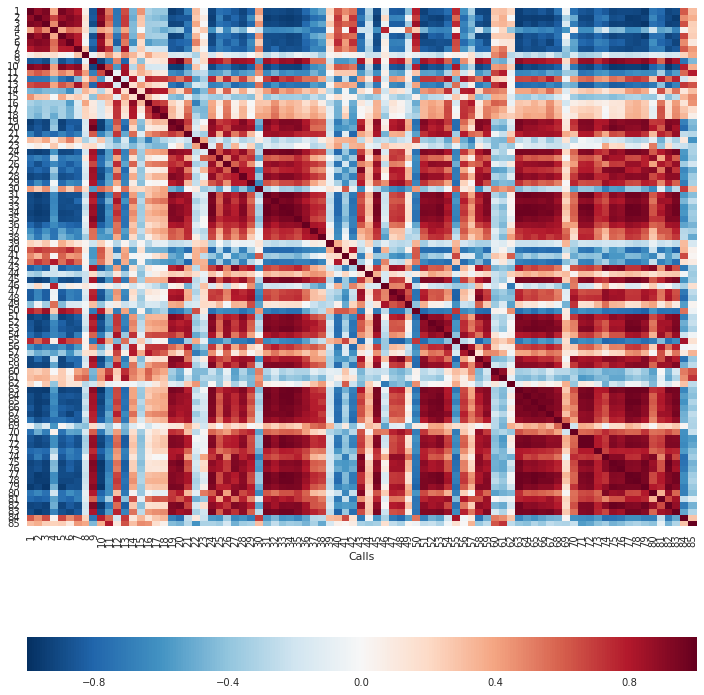

In [27]:
f = plt.figure(figsize=(12, 20))
gs = plt.GridSpec(15, 1)
map_ax = f.add_subplot(gs[0:-5])
sns.heatmap(corr, ax=map_ax,
            cbar_kws={"orientation": "horizontal"})
map_ax.set(xlabel="Calls");

In [28]:
callIn = region_based.pivot(index='region_id', columns='time', values='adjusted_callIn')
callIn.fillna(0, inplace=True)
x = callIn.as_matrix()
mean = np.mean(callIn, 0)
x_prime = np.zeros(shape=(85, mean.count()))
for i in range(0, 85):
    x_prime[i] = x[i] - mean
x_prime = np.transpose(x_prime)

xpp = pd.DataFrame(x_prime)
corr = xpp.corr('pearson')
corr.index = corr.index + 1
corr.columns = range(1,86)

f = plt.figure(figsize=(12, 20))
gs = plt.GridSpec(15, 1)
map_ax = f.add_subplot(gs[0:-5])
sns.heatmap(corr, ax=map_ax,
            cbar_kws={"orientation": "horizontal"})
map_ax.set(xlabel="Call-In");

KeyError: 'time'